# Installing Dependencies



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd drive/MyDrive/capuchin_bird_conservation/

[Errno 2] No such file or directory: 'drive/MyDrive/capuchin_bird_conservation/'
/content/drive/MyDrive/capuchin_bird_conservation


In [ ]:
!pip install tensorflow-io matplotlib


## Loading Dependencies

In [ ]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

# Building Data Loader Function

## Defining Paths

In [ ]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

## Building the Data Loader Function

In [ ]:

def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

## Plot Wave

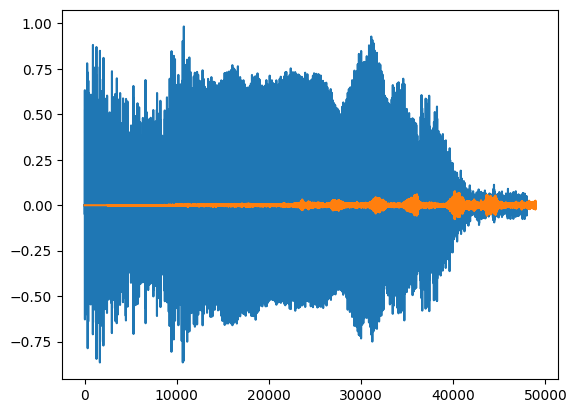

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Creating Tensorflow Dataset

## Defining Paths to
##                   Negative: Sounds which are not Capuchin
##                   Positive: Sounds of the Capuchin Bird

In [ ]:

POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

## Create Tensorflow Datasets

In [ ]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

## Add labels and Combine Positive and Negative Samples

In [ ]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [ ]:
data.shuffle(1000000).as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC22397-7.wav', 1.0)

# Determine Average Length of a Capuchin Call

## Calculate Wave Cycle Length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('data', 'Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

## Calculate Mean, Min and Max

In [ ]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [ ]:

tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [ ]:

tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

# Build Preprocessing Function to Convert to Spectrogram

## Build Preprocessing Function


In [ ]:
def preprocess(file_path, label):
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [ ]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)
wav

<tf.Tensor: shape=(48000,), dtype=float32, numpy=
array([ 8.9910554e-07, -2.7947258e-06,  7.0741157e-06, ...,
       -1.0823049e-02, -3.5766482e-03,  1.5143131e-02], dtype=float32)>

## Test Out the Function and Viz the Spectrogram

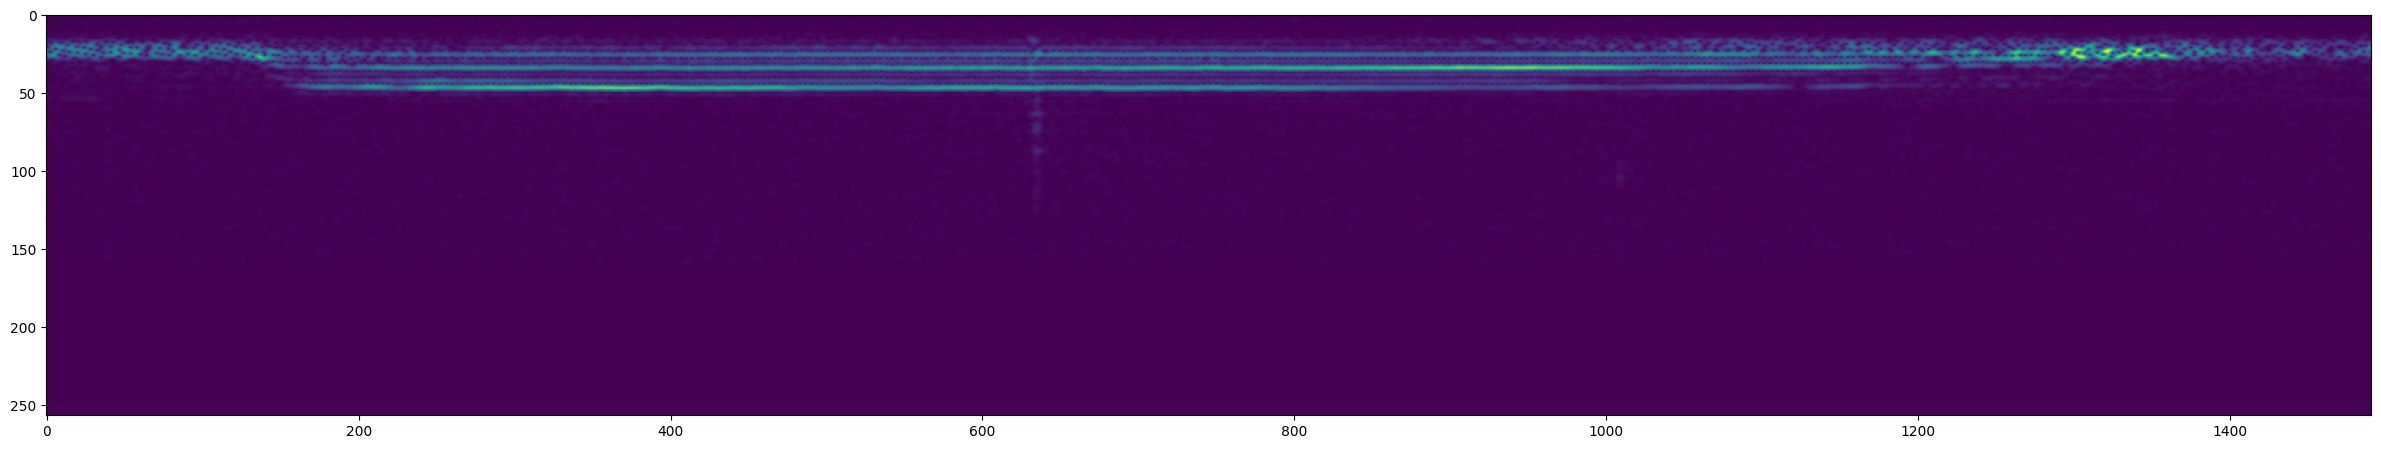

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

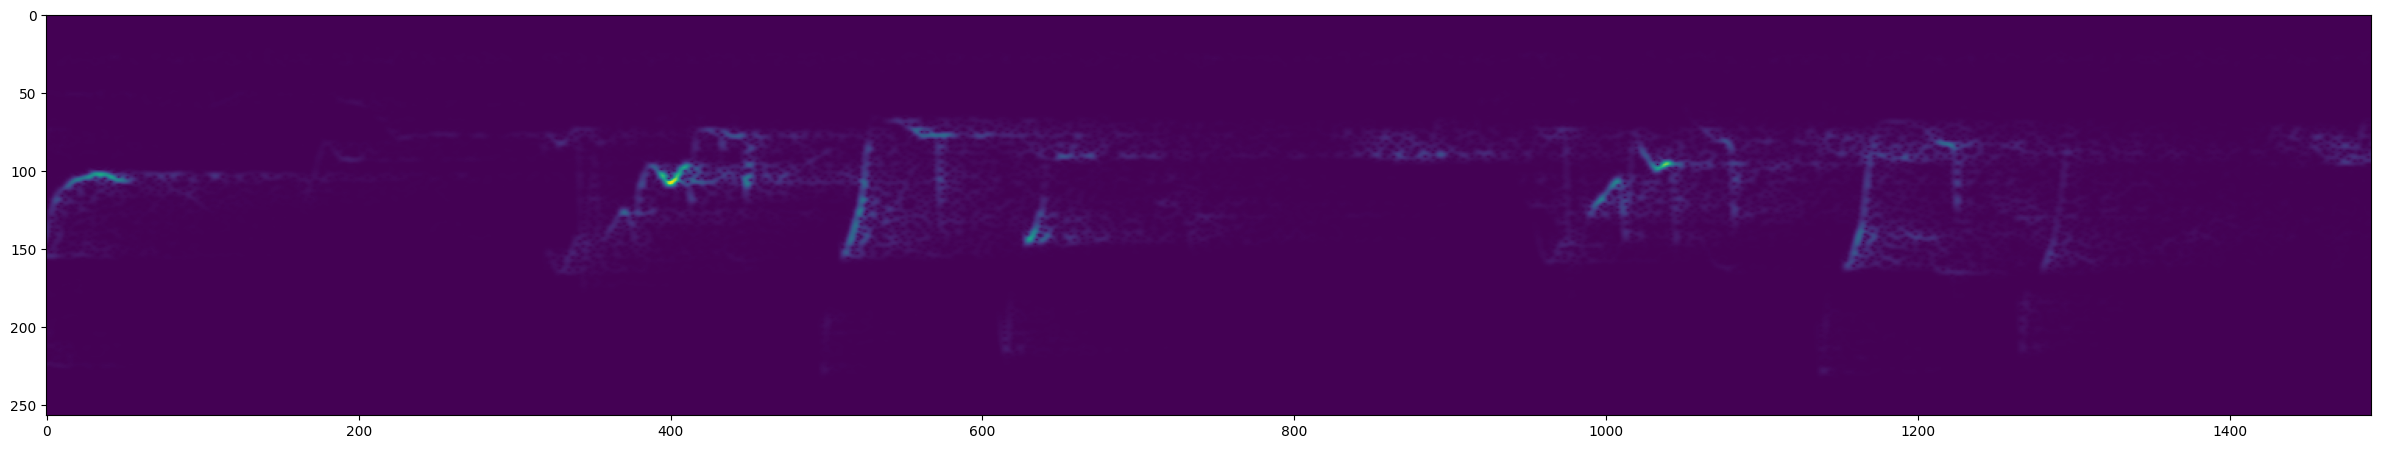

In [ ]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create Training and Testing Partitions

## Create a Tensorflow Data Pipeline

In [ ]:
# mapping the data to our preprocess function and building a spectrogram out of it
data = data.map(preprocess)
# caching it
data = data.cache()
# mixing up all our training samples
data = data.shuffle(buffer_size=1000)
# we're training it on 16 samples at a moment
data = data.batch(16)
#prefetch 8 examples to avoid CPU bottlenecks
data = data.prefetch(8)

## Split into Training and Testing Partitions

In [ ]:
len(data)

51

In [ ]:
len(data)*0.7

35.699999999999996

In [ ]:
train = data.take(36)
test = data.skip(36).take(15)

## Test One Batch

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
samples.shape

(16, 1491, 257, 1)

In [ ]:
labels

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1.],
      dtype=float32)

We have 16 (defined batch) clips, and the shape of each tensor is defined as the rest

# Build Deep Learning Model

## Load Tensorflow Dependencies

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

## Build Sequential Model, Compile and View Summary

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 1489, 255, 16)     160       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 744, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 742, 125, 16)      2320      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 371, 62, 16)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 368032)            0         
                                                                 
 dense_17 (Dense)            (None, 64)               

## Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10
36/36 [==============================] - 5s 92ms/step - loss: 0.7745 - recall_5: 0.8750 - precision_5: 0.7735 - val_loss: 0.0943 - val_recall_5: 1.0000 - val_precision_5: 0.9286
Epoch 2/10
36/36 [==============================] - 3s 85ms/step - loss: 0.0912 - recall_5: 0.9650 - precision_5: 0.9583 - val_loss: 0.0620 - val_recall_5: 0.9655 - val_precision_5: 0.9825
Epoch 3/10
36/36 [==============================] - 3s 85ms/step - loss: 0.0168 - recall_5: 0.9868 - precision_5: 0.9934 - val_loss: 0.0183 - val_recall_5: 1.0000 - val_precision_5: 0.9844
Epoch 4/10
36/36 [==============================] - 3s 92ms/step - loss: 0.0159 - recall_5: 0.9877 - precision_5: 0.9938 - val_loss: 0.0145 - val_recall_5: 1.0000 - val_precision_5: 0.9846
Epoch 5/10
36/36 [==============================] - 3s 83ms/step - loss: 0.0146 - recall_5: 1.0000 - precision_5: 0.9864 - val_loss: 0.0085 - val_recall_5: 1.0000 - val_precision_5: 1.0000
Epoch 6/10
36/36 [==============================] - 4s 

In [ ]:
hist.history

{'loss': [0.7745456695556641,
  0.09124455600976944,
  0.016826175153255463,
  0.01593279093503952,
  0.014604315161705017,
  0.01254040002822876,
  0.004919629544019699,
  0.006710916757583618,
  0.002423649188131094,
  0.0006889091455377638],
 'recall_5': [0.875,
  0.9650349617004395,
  0.9868420958518982,
  0.9876543283462524,
  1.0,
  0.9937888383865356,
  0.9935483932495117,
  0.993630588054657,
  1.0,
  1.0],
 'precision_5': [0.7734806537628174,
  0.9583333134651184,
  0.9933775067329407,
  0.9937888383865356,
  0.9863945841789246,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.09426206350326538,
  0.0620482861995697,
  0.018304821103811264,
  0.014462744817137718,
  0.008452476002275944,
  0.006021940149366856,
  0.009537819772958755,
  0.0006969873793423176,
  0.0013894657604396343,
  0.0008007673313841224],
 'val_recall_5': [1.0,
  0.9655172228813171,
  1.0,
  1.0,
  1.0,
  1.0,
  0.9852941036224365,
  1.0,
  1.0,
  1.0],
 'val_precision_5': [0.9285714030265808,
  0.98245

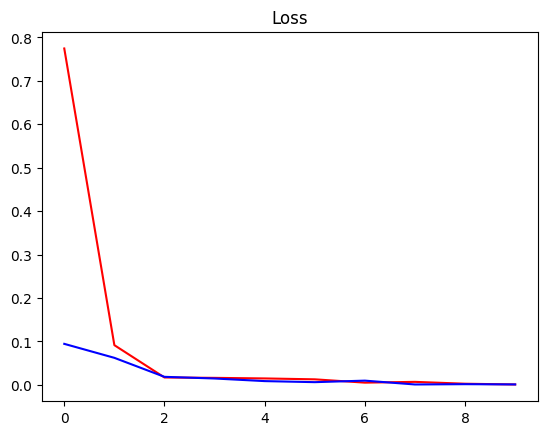

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

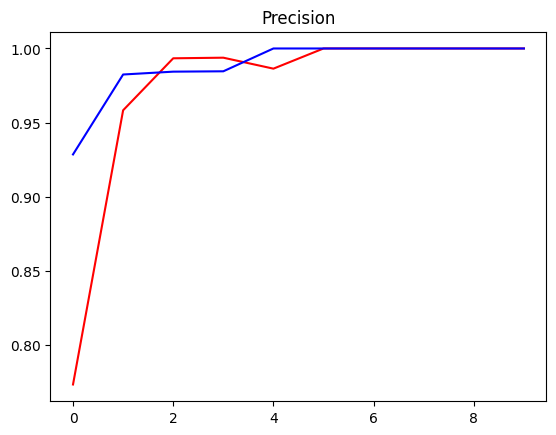

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision_5'], 'r')
plt.plot(hist.history['val_precision_5'], 'b')
plt.show()

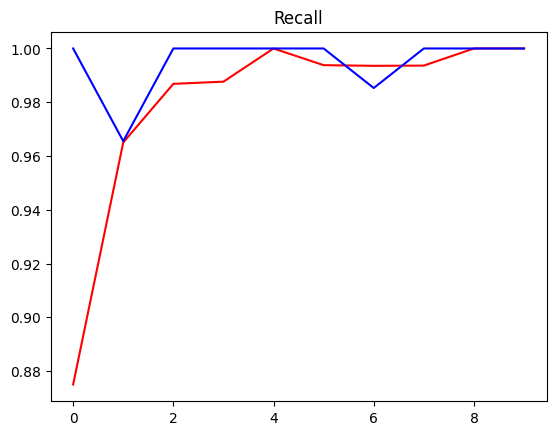

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_5'], 'r')
plt.plot(hist.history['val_recall_5'], 'b')
plt.show()

# Make a Prediction on a Single Clip

## Get One Batch and Make a Prediction

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 32ms/step


In [ ]:
yhat

array([[2.43673007e-12],
       [3.06299712e-12],
       [5.64248012e-06],
       [3.69269881e-09],
       [7.62102949e-28],
       [1.90020742e-13],
       [1.89134185e-31],
       [1.46229135e-08],
       [9.99999523e-01],
       [9.99910474e-01],
       [4.29531602e-19],
       [9.99995589e-01],
       [3.66003565e-06],
       [7.96412036e-13],
       [9.99940276e-01],
       [1.00000000e+00]], dtype=float32)

## Converting Logits to Classes

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
yhat

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1]

In [ ]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=5>

***5 capuchins were heard in that clip!!!***

In [ ]:
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=5.0>

***5 capuchins were heard in that clip too!!! -> Accurate prediction***

# Build Forest Parsing Functions

## Load up MP3s

In [ ]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

# Build Function to Convert Clips into Windowed Spectrograms

In [ ]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## Convert Longer Clips into Windows and Make Predictions

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:

yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 1s 408ms/step


## Group Consecutive Detections

In [ ]:
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

6

# Make Predictions

## Loop over all recordings and make predictions

In [ ]:
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)

    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)

    yhat = model.predict(audio_slices)

    results[file] = yhat

1/1 [==============================] - 0s 411ms/step


In [ ]:
results

{'recording_00.mp3': array([[6.0153093e-02],
        [5.2395845e-03],
        [1.8386826e-02],
        [9.3465728e-01],
        [1.0000000e+00],
        [7.0825627e-04],
        [8.0466503e-04],
        [2.3733454e-03],
        [3.7005504e-03],
        [1.6629148e-02],
        [6.7843064e-03],
        [5.7563917e-03],
        [3.6537049e-03],
        [9.9985135e-01],
        [1.0000000e+00],
        [1.4825093e-03],
        [2.1764808e-09],
        [2.3110271e-03],
        [2.0219581e-02],
        [2.3090323e-02],
        [2.0014016e-02],
        [3.7854468e-03],
        [7.8644365e-02],
        [9.5013791e-01],
        [1.0000000e+00],
        [4.6809058e-05],
        [9.3010669e-05],
        [5.2120369e-02],
        [1.8477645e-02],
        [3.0977091e-02],
        [4.4903709e-03],
        [7.2944194e-02],
        [2.7675694e-03],
        [2.0775837e-05],
        [1.4880307e-01],
        [1.7567802e-02],
        [1.0000000e+00],
        [2.0291362e-05],
        [3.3729482e-02],
     

## Convert Predictions into Classes

In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## Group Consecutive Detections

In [ ]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 1,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 5,
 'recording_17.mp3': 18,
 'recording_18.mp3': 1,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_27.mp3': 0,
 'recording_25.mp3': 12,
 'recording_26.mp3': 2,
 'recording_29.mp3': 0,
 'recording_28.mp3': 13,
 'recording_30.mp3': 1,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_34.mp3': 4,
 'recording_33.mp3': 0,
 'recording_35.mp3': 0,
 'recording_38.mp3': 18,
 'recording_37.mp3': 3,
 'recording_36.mp3': 0,
 'recording_40.mp3': 1,
 'recording_39.mp3': 3,
 'recording

## Export Results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])